# load data

In [43]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score

In [44]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

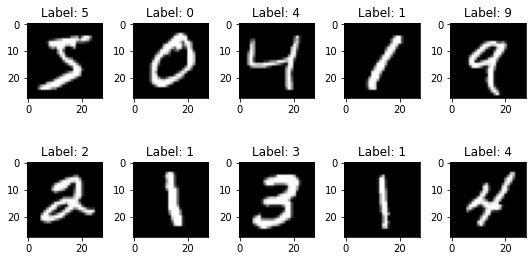

In [45]:
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

# build model

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten

In [6]:
x = Input(shape=(28, 28))  # shape of input
z = Flatten()(x)  # 28x28 -> 784
z = Dense(units=128, activation='relu')(z)  # dense + ReLU
p = Dense(units=10, activation='softmax')(z)  # dense + softmax

model = Model(
    inputs=x,
    outputs=p,
)  # build DNN model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])  # compile model

In [7]:
# callbacks
callbacks = [
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath=os.path.join('models', 'DNN', 'test.h5'), save_best_only=True),
]

In [9]:
# train
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 31us/sample - loss: 4.4174 - acc: 0.8581 - val_loss: 1.1078 - val_acc: 0.8808
Epoch 2/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.6663 - acc: 0.9026 - val_loss: 0.5716 - val_acc: 0.9073
Epoch 3/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.3501 - acc: 0.9285 - val_loss: 0.4796 - val_acc: 0.9208
Epoch 4/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.2421 - acc: 0.9434 - val_loss: 0.4246 - val_acc: 0.9248
Epoch 5/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.1833 - acc: 0.9539 - val_loss: 0.3822 - val_acc: 0.9368
Epoch 6/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.1597 - acc: 0.9579 - val_loss: 0.3789 - val_acc: 0.9355
Epoch 7/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.1484 - acc: 0.9612 - val_l

In [10]:
# see accuracy

accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))

0.9479

The accuracy of this model is 94.79% (in the author's environment.) Pretty good!

このモデルの精度は（筆者の環境では） 94.79% です。
悪くない！

# compare models

In [24]:
from collections import OrderedDict

class DenseModel:
    def __init__(self, layers=1, hid_dim=128):
        self.input = Input(shape=(28, 28), name='input')
        self.flatten = Flatten(name='flatten')
        self.denses = OrderedDict()
        for i in range(layers):
            name = 'dense_{}'.format(i)
            self.denses[name] = Dense(units=hid_dim, activation='relu', name=name)
        self.last = Dense(units=10, activation='softmax', name='last')
    
    
    def build(self):
        x = self.input
        z = self.flatten(x)
        for dense in self.denses.values():
            z = dense(z)
        p = self.last(z)
        
        model = Model(inputs=x, outputs=p)
        
        return model

In [30]:
dim_hidden_layres = [2**i for i in range(11)]
n_layers = range(1, 4)

df_accuracy = pd.DataFrame()

for layers in n_layers:
    for hid_dim in dim_hidden_layres:
        print('========', 'layers:', layers, '; hid_dim:', hid_dim, '========')
        model = DenseModel(layers=layers, hid_dim=hid_dim)
        model = model.build()
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
        callbacks = [
            EarlyStopping(patience=3),
            ModelCheckpoint(filepath=os.path.join('models', 'DNN', 'model_{}_{}.h5'.format(layers, hid_dim)), save_best_only=True),
        ]
        model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)
        acc = accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))
        
        df_accuracy = pd.concat([df_accuracy, pd.DataFrame([[layers, hid_dim, acc]], columns=['layers', 'hid_dim', 'accuracy'])])

======== layers: 1 ; hid_dim: 1 ========
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 23us/sample - loss: 2.3027 - acc: 0.1138 - val_loss: 2.3018 - val_acc: 0.1061
Epoch 2/100
48000/48000 [==============================] - 1s 18us/sample - loss: 2.3010 - acc: 0.1140 - val_loss: 2.3011 - val_acc: 0.1065
Epoch 3/100
48000/48000 [==============================] - 1s 17us/sample - loss: 2.2912 - acc: 0.1210 - val_loss: 2.2093 - val_acc: 0.1506
Epoch 4/100
48000/48000 [==============================] - 1s 17us/sample - loss: 2.1874 - acc: 0.1694 - val_loss: 2.1329 - val_acc: 0.1814
Epoch 5/100
48000/48000 [==============================] - 1s 19us/sample - loss: 2.1305 - acc: 0.1887 - val_loss: 2.0865 - val_acc: 0.2006
Epoch 6/100
48000/48000 [==============================] - 1s 19us/sample - loss: 2.0829 - acc: 0.2017 - val_loss: 2.0559 - val_acc: 0.2040
Epoch 7/100
48000/48000 [==============================] - 1s 19us/sa

In [52]:
df_accuracy.set_index(['layers', 'hid_dim']).unstack()

accuracy                                                          \
hid_dim     1       2       4       8       16      32      64      128    
layers                                                                     
1         0.2991  0.6508  0.1134  0.8459  0.9019  0.9325  0.9496  0.9499   
2         0.1135  0.1136  0.1136  0.8395  0.9081  0.9303  0.9421  0.9497   
3         0.1135  0.1135  0.6127  0.8702  0.9253  0.9118  0.9566  0.9649   

                                 
hid_dim    256     512     1024  
layers                           
1        0.9633  0.9680  0.9636  
2        0.9634  0.9659  0.9577  
3        0.9595  0.9666  0.9724